# Analyse d'incertitudes

In [1]:
import bw2io as bi # ensemble des fonctions et classes pour importer et exporter (input/output)
import bw2data as bd # ... pour gérer les données du projet
import bw2calc as bc # ... pour faire des opérations
import bw2analyzer as ba # ... pour interpréter les résultats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

bd.projects.set_current('2025-06-10_ecoinvent_311')
eidb = bd.Database('ecoinvent-3.11-cutoff')
biodb = bd.Database('ecoinvent-3.11-biosphere')
fgdb = bd.Database('betons_armes')

beton_A = fgdb.search("Béton A")[0]
meth = [m for m in bd.methods if 'EF v3.1' in m[1] and 'no LT' not in m[1]]
gwp100 = [ind for ind in meth if 'GWP100' in str(ind) and 'biogenic' not in str(ind) and 'fossil' not in str(ind) and 'land' not in str(ind)][0]

### ACV statique vs ACV stochastique

Nous commençons par réaliser une ACV de béton A prenant en compte les incertitudes sur les valeurs des flux élémentaires et intermédiaires, données par ecoinvent (sur les coefficients des matrices A et B) et sur les facteurs de caractérisation (coefficients de la matrice C). Pour commencer au plus simple, nous nous contentons de faire le calcul uniquement sur l'indicateur de potentiel de réchauffement climatique à 100 ans.

Nous réalisons peu de lancers de Monte-Carlo (200) par économie de temps. 

In [ ]:
n_MC = 200
lca_unc_A = bc.LCA(demand={beton_A.id : 1.0},method=gwp100,use_distributions=True) # L'argument use_distribution=True indique de préparer les matrices pour des tirages aléatoires
lca_unc_A.lci()
lca_unc_A.lcia()

scores_A = [lca_unc_A.score for _ in zip(lca_unc_A,range(n_MC))]

In [4]:
scores_A # On obtient une liste de résultats

[645.6428074211059,
 656.1895291448288,
 533.8356256656579,
 662.7837490516565,
 691.4480460890263,
 606.469502878343,
 541.9266861327955,
 589.4993207863007,
 562.160786189143,
 560.0323333029872,
 827.0925737588029,
 529.0469858537458,
 574.7809740565805,
 626.2844725833872,
 558.1805172891441,
 714.648163908665,
 473.8243528223982,
 609.4854983673735,
 593.1486426729582,
 602.9896021353743,
 704.8209645211457,
 557.8263379896154,
 649.4764047250936,
 615.2108613739837,
 553.7202044185321,
 670.2748232443861,
 561.8526457063546,
 548.9627735932414,
 537.9577379348825,
 564.5837126823506,
 597.878008109326,
 501.93501818743596,
 663.4802333970251,
 637.613548178375,
 558.4316075647548,
 599.2215280399082,
 680.5817879352978,
 665.9855540138107,
 677.5605527615241,
 615.3485125005219,
 592.2702838089538,
 650.4395418852994,
 546.744498278865,
 546.9729486065423,
 519.8111713874587,
 524.6024839479012,
 708.9692896365862,
 589.4832067580573,
 538.0442879536607,
 618.3982286968335,
 483.

In [6]:

scores_mean = np.mean(scores_A)
scores_med = np.median(scores_A)
print('moyenne : ',scores_mean,'médiane : ',scores_med)

moyenne :  601.0874989332984 médiane :  591.7049044857683


On peut calculer le score d'impact par ACV sans tirage aléatoire, afin de comparer les scores.

In [7]:
lca = bc.LCA(demand={beton_A.id : 1.0},method=gwp100)
lca.lci()
lca.lcia()

s = lca.score

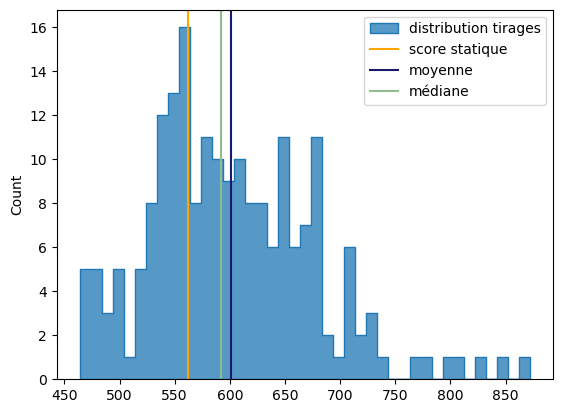

In [9]:


fig, ax = plt.subplots()
sns.histplot(scores_A,binwidth=10,element='step',label = "distribution tirages",legend=True) # Tracé de la distribution
ax.axvline(x=s, color='orange',label = 'score statique') # Tracé d'une ligne verticale à la valeur en calcul statique
ax.axvline(x=scores_mean, color='midnightblue',label = 'moyenne') # Tracé à la moyenne des tirages
ax.axvline(x=scores_med, color='darkseagreen',label = 'médiane') # Tracé à la médiane des tirages
ax.legend(loc='upper right')


On remarque un décalage entre le score sans tirage et la moyenne des tirages. Pourquoi ?

In [72]:
exchanges = [exc.input.exchanges() for exc in beton_A.technosphere()]
uncertainty_types = [[e.uncertainty['uncertainty type'] for e in exc] for exc in exchanges]
print([u for u in uncertainty_types]) # 0 veut dire que l'incertitude n'est pas renseignée, 2 que la distribution est lognormale :

[[0, 0, 2, 2, 2], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2], [0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 0, 0, 0, 2, 2, 2, 2], [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]


Cela vient d'un grand nombre d'incertitudes d'ecoinvent qui suivent une loi lognormale, choisie pour de multiples raisons,  notamment pour éviter les valeurs négatives. Pour creuser ce sujet, vous pouvez lire [ce billet](https://chris.mutel.org/ecoinvent-lognormal.html) de Chris Mutel et [cet article](https://link.springer.com/article/10.1007/s11367-013-0670-5) de Ciroth et al. Or la valeur statique des procédés ecoinvent est la médiane de cette distribution ($e^{\mu}$ si $\mu$ est la moyenne de la distribution normale sous-jacente), qui est toujours inférieure à la moyenne ($e^{\mu +\frac{\sigma^2}{2}}$).

D'où vient l'incertitude ? De la matrice A, de la matrice B, ou de C ? Nous pouvons utiliser un argument pratique de la fonction de calcul ACV de bright qui permet un usage sélectif des distribution :

### Comparaison sous incertitudes

On veut comparer désormais le béton A et le béton B.

In [11]:
beton_B = fgdb.search("Béton B")[0]

On peut commencer par faire des tirages alétoires sur l'indice de potentiel de réchauffement climatique pour une unité de béton B, comme on l'a fait précédemment pour le béton A :

In [52]:
lca_unc_B = bc.LCA(demand={beton_B.id : 1.0},method=gwp100,use_distributions=True) # L'argument use_distribution=True indique de préparer les matrices pour des tirages aléatoires
lca_unc_B.lci()
lca_unc_B.lcia()

scores_B = [lca_unc_B.score for _ in zip(lca_unc_B,range(n_MC))]

On peut désormais tracer les deux distributions de résultats sur le même graphe :

Text(0.5, 0, "('ecoinvent-3.11', 'EF v3.1', 'climate change', 'global warming potential (GWP100)')")

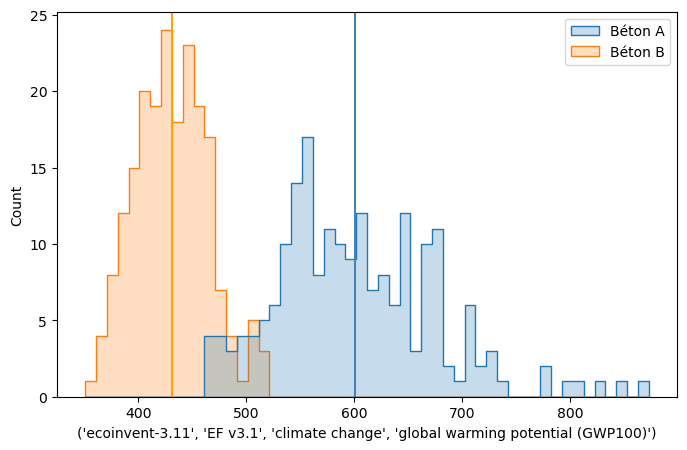

In [53]:
fig, ax = plt.subplots(figsize=(8,5))

sns.histplot({'Béton A' : scores_A,'Béton B' : scores_B},element='step',binwidth=10)
ax.axvline(x=np.mean(scores_A), color='steelblue',label = 'moyenne Béton A') # Tracé à la moyenne des tirages
ax.axvline(x=np.mean(scores_B), color='orange',label = 'moyenne Béton B') # Tracé à la médiane des tirages
ax.set_xlabel(str(gwp100))



Qu'en pensez-vous ? Sauriez-vous arbitrer entre ces deux bétons ?

#### Dépendante, indépendante

Nous avons réalisé des tirages indépendants, au sens où nous avons tiré indépendamment n_MC fois les coefficients des matrices du calcul ACV pour chaque béton. Nous pourrions considérer que lorsque un coefficient est tiré (par exemple un coefficient de la matrice environnementale comme l'émission de CO2 dans l'air pour une production d'1 kWh électrique en France) pour le béton A il doit rester le même pour le béton B, afin de  ne pas générer de différence là où les deux procédés sont identiques (pour poursuivre l'exemple, on fait l'hypothèse que les bétons A et B sont produits avec le même mix électrique).

In [74]:
demands = [{beton_A.id : 1.0},{beton_B.id : 1.0}] # liste des demandes
lca = bc.LCA(demand=demands[0],method=gwp100,use_distributions=True) # On initialise l'ACV, la demande ici importe peu
lca.lci() 
lca.lcia()
tirages = {'Béton A' : [],'Béton B' : []} # dictionnaire de listes vides dans lesquelles on stockera les résultats

for _ in range(n_MC) : # On fait n_MC tirages
    next(lca) # On tire les matrices
    tmp = [] # On crée une liste temporaire pour stocker les résultats sur les deux demandes
    lca.redo_lcia(demands[0])
    tirages['Béton A' ].append(lca.score)
    lca.redo_lcia(demands[1])
    tirages['Béton B' ].append(lca.score)

In [ ]:
df_comp_dep = pd.DataFrame(tirages)
#df_comp_dep['Delta'] = df_comp_dep['Béton A']-df_comp_dep['Béton B'] # Différence terme à terme
df_comp_dep

In [78]:
df_comp_inde = pd.DataFrame({'Béton A':scores_A,'Béton B':scores_B,})
#df_comp_inde['Delta'] = df_comp_inde['Béton A']-df_comp_inde['Béton B'] # Différence terme à terme

Text(0.5, 0, 'Différence des tirages termes à termes')

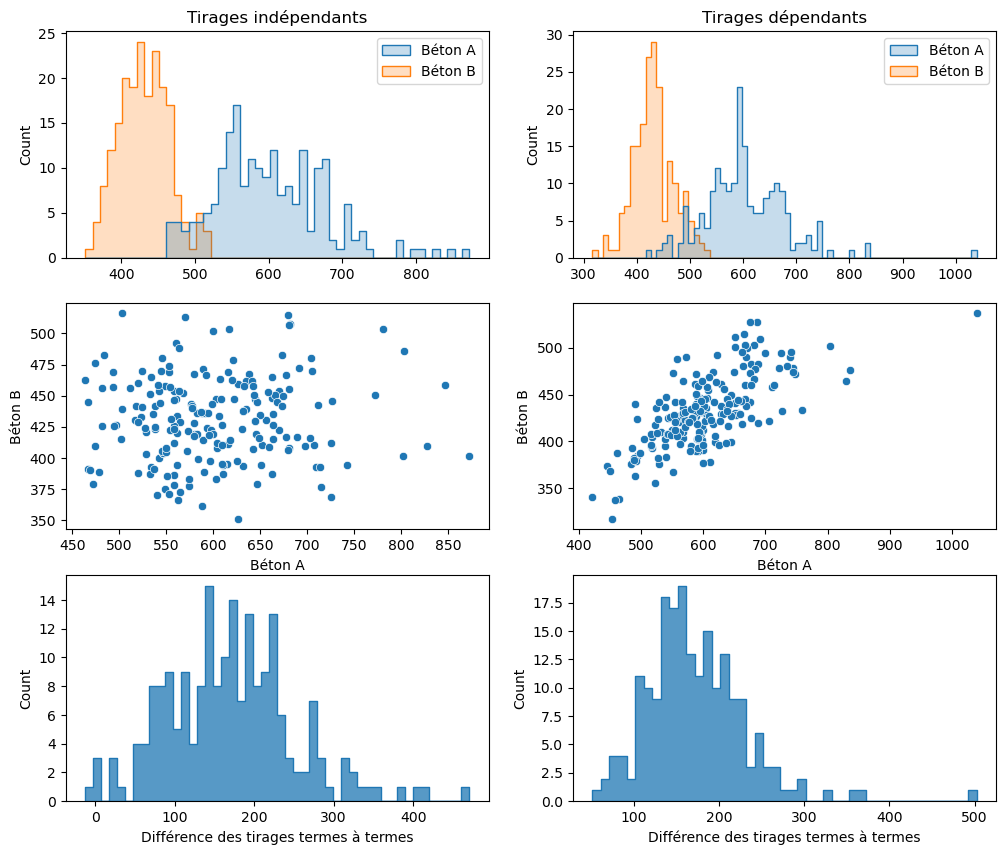

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(12,10))
sns.histplot(df_comp_inde,element='step',ax=ax[0,0],binwidth=10)
sns.histplot(df_comp_dep,element='step',ax=ax[0,1],binwidth=10)
sns.scatterplot(df_comp_inde,x='Béton A',y='Béton B',ax=ax[1,0])
sns.scatterplot(df_comp_dep,x='Béton A',y='Béton B',ax=ax[1,1])
sns.histplot(df_comp_inde['Béton A']-df_comp_inde['Béton B'],element='step',ax=ax[2,0],binwidth=10)
sns.histplot(df_comp_dep['Béton A']-df_comp_dep['Béton B'],element='step',ax=ax[2,1],binwidth=10)
ax[0,0].set_title(f"Tirages indépendants")
ax[0,0].set_xlim(300,900)
ax[0,1].set_title(f"Tirages dépendants")
ax[0,1].set_xlim(300,900)
ax[2,0].set_xlabel(f"Différence des tirages termes à termes")
ax[2,1].set_xlabel(f"Différence des tirages termes à termes")

On peut confirmer par le calcul ce que l'on aperçoit visuellement, à savoir que la dépendance des comparaisons permet de réduire la dispersion de la différence terme à terme des tirages :

In [86]:
df_stats = pd.DataFrame(columns=['Indépendante','Dépendante'],index=['moyenne',"médiane","écart type"])
delta_inde = df_comp_inde['Béton A']-df_comp_inde['Béton B']
delta_dep = df_comp_dep['Béton A']-df_comp_dep['Béton B']
df_stats['Indépendante'] = [np.mean(delta_inde),np.median(delta_inde),np.std(delta_inde)]
df_stats['Dépendante'] = [np.mean(delta_dep),np.median(delta_dep),np.std(delta_dep)]
df_stats

,Indépendante,Dépendante
moyenne,170.139071,172.191925
médiane,168.024046,163.671843
écart type,80.877882,58.168664


On illustre ce que veut dire une comparaison dépendante/indépendante en comparant le béton A à lui-meme, en prenant en compte les incertitudes

In [63]:
demand = {beton_A.id : 1.0} # liste des demandes
lca = bc.LCA(demand=demand,method=gwp100,use_distributions=True) # On initialise l'ACV
lca.lci() 
lca.lcia()
tirages = {'tirage_1' : [],'tirage_2' : []} # dictionnaire de listes vides dans lesquelles on stockera les résultats

for _ in range(n_MC) : # On fait n_MC tirages
    next(lca) # On tire les matrices
    tmp = [] # On crée une liste temporaire pour stocker les résultats sur les deux demandes
    lca.redo_lcia(demand)
    tirages['tirage_1'].append(lca.score)
    lca.redo_lcia(demand)
    tirages['tirage_2'].append(lca.score)



In [67]:
df_tirages_dep = pd.DataFrame(tirages) #On organise nos résultats en une table plus facile à visualiser et tracer
df_tirages_dep

,tirage_1,tirage_2
0,719.688884,719.688884
1,501.345678,501.345678
2,623.882524,623.882524
3,641.748842,641.748842
4,472.838852,472.838852
...,...,...
195,633.629730,633.629730
196,630.801232,630.801232
197,632.768495,632.768495
198,499.234737,499.234737


In [66]:
lca = bc.LCA(demand=demand,method=gwp100,use_distributions=True) # On initialise l'ACV
lca.lci() 
lca.lcia()
df_tirages_inde = pd.DataFrame({'tirage_1':[lca.score for _ in zip(lca,range(n_MC))],'tirage_2':[lca.score for _ in zip(lca,range(n_MC))]})

Text(0.5, 1.0, 'Tirages dépendants')

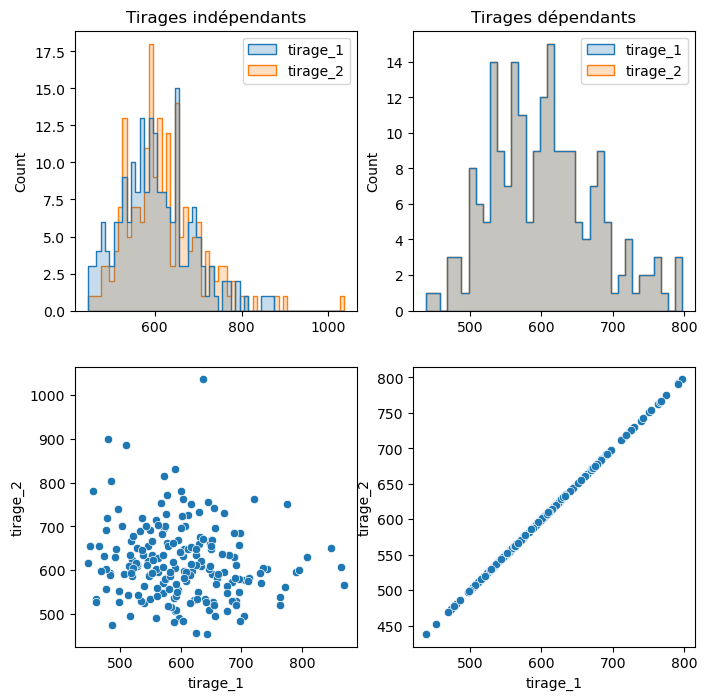

In [87]:
fig, ax = plt.subplots(2,2,figsize=(8,8))
sns.histplot(df_tirages_inde,element='step',ax=ax[0,0],binwidth=10)
sns.histplot(df_tirages_dep,element='step',ax=ax[0,1],binwidth=10)
sns.scatterplot(df_tirages_inde,x='tirage_1',y='tirage_2',ax=ax[1,0])
sns.scatterplot(df_tirages_dep,x='tirage_1',y='tirage_2',ax=ax[1,1])
ax[0,0].set_title(f"Tirages indépendants")
ax[0,1].set_title(f"Tirages dépendants")


Que s'est-il passé ?

In [ ]:
np.des

Sauriez-vous arbitrer entre les bétons ? Pourquoi ?

#### Indice de discernabilité ??

Les manières de faire sont nombreuses